<h1>
The Tipping Problem - The Hard Way

# Import das bibliotecas necessárias

In [1]:
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt

The ‘tipping problem’ is commonly used to illustrate the power of fuzzy logic principles to generate complex behavior from a compact, intuitive set of expert rules.

# Input variables

A number of variables play into the decision about how much to tip while dining. Consider two of them:
* **quality**: Quality of the food
* **service**: Quality of the service

# Output variable

The output variable is simply the tip amount, in percentage points:

* **tip**: Percente of bill to addd as tip

For the purposes of discussion, let’s say we need ‘high’, ‘medium’, and ‘low’ membership functions for both input variables and our output variable. These are defined in scikit-fuzzy as follows

# Generate universe variables
   * Quality and service on subjective ranges [0, 10]
   * Tip has a range of [0, 25] in units of percentage points

In [2]:
x_qual = np.arange(0, 11, 1)
x_serv = np.arange(0, 11, 1)
x_tip  = np.arange(0, 26, 1)

## Generate fuzzy membership functions

In [3]:
qual_lo = fuzz.trimf(x_qual, [0, 0, 5])
qual_md = fuzz.trimf(x_qual, [0, 5, 10])
qual_hi = fuzz.trimf(x_qual, [5, 10, 10])
serv_lo = fuzz.trimf(x_serv, [0, 0, 5])
serv_md = fuzz.trimf(x_serv, [0, 5, 10])
serv_hi = fuzz.trimf(x_serv, [5, 10, 10])
tip_lo = fuzz.trimf(x_tip, [0, 0, 13])
tip_md = fuzz.trimf(x_tip, [0, 13, 25])
tip_hi = fuzz.trimf(x_tip, [13, 25, 25])

## Visualize these universes and membership functions

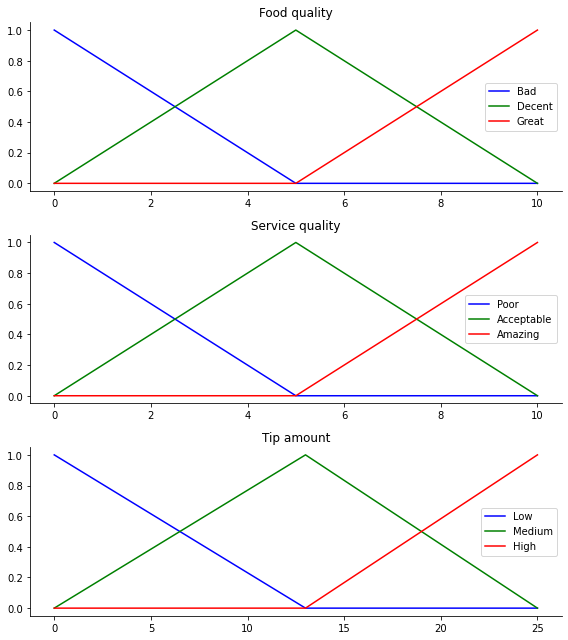

In [4]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(8, 9))

ax0.plot(x_qual, qual_lo, 'b', linewidth=1.5, label='Bad')
ax0.plot(x_qual, qual_md, 'g', linewidth=1.5, label='Decent')
ax0.plot(x_qual, qual_hi, 'r', linewidth=1.5, label='Great')
ax0.set_title('Food quality')
ax0.legend()

ax1.plot(x_serv, serv_lo, 'b', linewidth=1.5, label='Poor')
ax1.plot(x_serv, serv_md, 'g', linewidth=1.5, label='Acceptable')
ax1.plot(x_serv, serv_hi, 'r', linewidth=1.5, label='Amazing')
ax1.set_title('Service quality')
ax1.legend()

ax2.plot(x_tip, tip_lo, 'b', linewidth=1.5, label='Low')
ax2.plot(x_tip, tip_md, 'g', linewidth=1.5, label='Medium')
ax2.plot(x_tip, tip_hi, 'r', linewidth=1.5, label='High')
ax2.set_title('Tip amount')
ax2.legend()

# Turn off top/right axes
for ax in (ax0, ax1, ax2):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

plt.tight_layout()

# Fuzzy rules

Now, to make these triangles useful, we define the fuzzy relationship between input and output variables. For the purposes of our example, consider three simple rules:

1. If the food is bad OR the service is poor, then the tip will be low
2. If the service is acceptable, then the tip will be medium
3. If the food is great OR the service is amazing, then the tip will be high.

Most people would agree on these rules, but the rules are fuzzy. Mapping the imprecise rules into a defined, actionable tip is a challenge. This is the kind of task at which fuzzy logic excels.
Rule application

What would the tip be in the following circumstance:

* Food quality was **6.5**
* Service was **9.8**


In [5]:
# We need the activation of our fuzzy membership functions at these values.
# The exact values 6.5 and 9.8 do not exist on our universes...
# This is what fuzz.interp_membership exists for!
qual_level_lo = fuzz.interp_membership(x_qual, qual_lo, 6.5)
qual_level_md = fuzz.interp_membership(x_qual, qual_md, 6.5)
qual_level_hi = fuzz.interp_membership(x_qual, qual_hi, 6.5)

serv_level_lo = fuzz.interp_membership(x_serv, serv_lo, 9.8)
serv_level_md = fuzz.interp_membership(x_serv, serv_md, 9.8)
serv_level_hi = fuzz.interp_membership(x_serv, serv_hi, 9.8)

# Now we take our rules and apply them. Rule 1 concerns bad food OR service.
# The OR operator means we take the maximum of these two.
active_rule1 = np.fmax(qual_level_lo, serv_level_lo)

# Now we apply this by clipping the top off the corresponding output
# membership function with `np.fmin`
tip_activation_lo = np.fmin(active_rule1, tip_lo)  # removed entirely to 0

# For rule 2 we connect acceptable service to medium tipping
tip_activation_md = np.fmin(serv_level_md, tip_md)

# For rule 3 we connect high service OR high food with high tipping
active_rule3 = np.fmax(qual_level_hi, serv_level_hi)
tip_activation_hi = np.fmin(active_rule3, tip_hi)
tip0 = np.zeros_like(x_tip)

## Visualize this

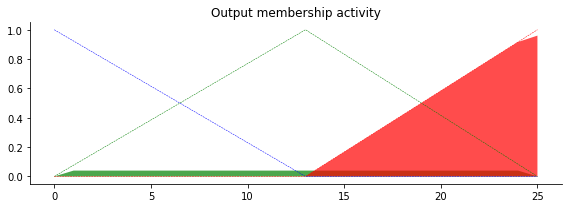

In [6]:
fig, ax0 = plt.subplots(figsize=(8, 3))

ax0.fill_between(x_tip, tip0, tip_activation_lo, facecolor='b', alpha=0.7)
ax0.plot(x_tip, tip_lo, 'b', linewidth=0.5, linestyle='--', )
ax0.fill_between(x_tip, tip0, tip_activation_md, facecolor='g', alpha=0.7)
ax0.plot(x_tip, tip_md, 'g', linewidth=0.5, linestyle='--')
ax0.fill_between(x_tip, tip0, tip_activation_hi, facecolor='r', alpha=0.7)
ax0.plot(x_tip, tip_hi, 'r', linewidth=0.5, linestyle='--')
ax0.set_title('Output membership activity')

# Turn off top/right axes
for ax in (ax0,):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

plt.tight_layout()

# Rule aggregation

With the activity of each output membership function known, all output membership functions must be combined. This is typically done using a maximum operator. This step is also known as aggregation.

# Defuzzification

Finally, to get a real world answer, we return to crisp logic from the world of fuzzy membership functions. For the purposes of this example the centroid method will be used.

# The result

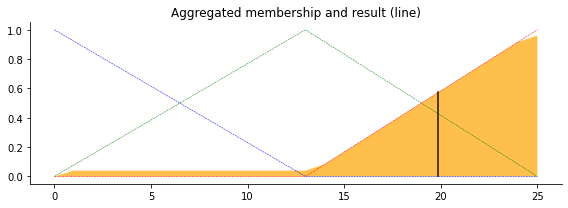

In [7]:
#Aggregate all three output membership functions together
aggregated = np.fmax(tip_activation_lo,
                     np.fmax(tip_activation_md, tip_activation_hi))

# Calculate defuzzified result
tip = fuzz.defuzz(x_tip, aggregated, 'centroid')
tip_activation = fuzz.interp_membership(x_tip, aggregated, tip) # for plot

# Visualize this
fig, ax0 = plt.subplots(figsize=(8, 3))

ax0.plot(x_tip, tip_lo, 'b', linewidth=0.5, linestyle='--', )
ax0.plot(x_tip, tip_md, 'g', linewidth=0.5, linestyle='--')
ax0.plot(x_tip, tip_hi, 'r', linewidth=0.5, linestyle='--')
ax0.fill_between(x_tip, tip0, aggregated, facecolor='Orange', alpha=0.7)
ax0.plot([tip, tip], [0, tip_activation], 'k', linewidth=1.5, alpha=0.9)
ax0.set_title('Aggregated membership and result (line)')

# Turn off top/right axes
for ax in (ax0,):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

plt.tight_layout()

The power of fuzzy systems is allowing complicated, intuitive behavior based on a sparse system of rules with minimal overhead. Note our membership function universes were coarse, only defined at the integers, but fuzz.interp_membership allowed the effective resolution to increase on demand. This system can respond to arbitrarily small changes in inputs, and the processing burden is minimal.